# **Identificación de Imágenes Auténticas y Sintéticas : Abordando los Desafíos de las Imágenes Sintéticas en la Sociedad Actual**

**Contenido**
1. [Configuración del Entorno](#title1)
2. [Construcción del Conjunto de Datos](#title2)
3. [Creación del Modelo](#title3)

## Configuración del Entorno<a name="title1"></a>

In [1]:
import tensorflow as tf
print(tf.config.experimental.list_physical_devices("GPU"))
print(tf.__version__)
# Para limitar la memoria que usa la GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar TensorFlow para que solo utilice la GPU si es necesario
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Configuración de GPU completada")
    except RuntimeError as e:
        print(e)
# Verifica que la GPU está disponible
print("¿GPU está disponible?:", tf.config.list_physical_devices('GPU'))
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import gc
import tensorflow as tf
from keras import backend as K

# Limpiar la memoria del backend
K.clear_session()
# Forzar la recolección de basura
gc.collect()


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0
Configuración de GPU completada
¿GPU está disponible?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


0

In [ ]:
# Limpiar la memoria del backend
K.clear_session()
# Forzar la recolección de basura
gc.collect()

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import class_weight

In [5]:
#@title Importar todas las librerías de uso.

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import glob
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, SpatialDropout2D
from tensorflow.keras.metrics import Accuracy, AUC, Precision, Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from sklearn import metrics
import matplotlib.image as mpmig
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

sns.set_theme()

## Construcción del Conjunto de Datos y Preprocesandolos<a name="title2"></a>

Fuente: https://www.kaggle.com/datasets/kaustubhdhote/human-faces-dataset & https://www.kaggle.com/datasets/hamzaboulahia/hardfakevsrealfaces/code

In [3]:
# Parámetros
batch_size = 32
img_height = 224  # Requerido por MobileNetV2
img_width = 224
epochs = 10

# Directorios de datos
train_folder = './Data/Train'
test_folder = './Data/Test'

# Cargar datasets
train_dataset = image_dataset_from_directory(
    train_folder,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

validation_dataset = image_dataset_from_directory(
    train_folder,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_dataset = image_dataset_from_directory(
    test_folder,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Capturar class_names antes de prefetch
class_names = train_dataset.class_names
print("Clases:", class_names)

# Aplicar prefetch
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 9630 files belonging to 2 classes.
Using 7704 files for training.
Found 9630 files belonging to 2 classes.
Using 1926 files for validation.
Found 1289 files belonging to 2 classes.
Clases: ['Fake', 'Real']


In [4]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
])

In [5]:
# Cargar el modelo base preentrenado sin las capas superiores
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

# Congelar las capas del modelo base para evitar entrenarlas
base_model.trainable = False

# Crear la cabecera personalizada para nuestro problema
global_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(1, activation='sigmoid')  # Usar sigmoid para clasificación binaria


# Modelo<a name="title3"></a>



In [6]:
#@title Construcción del modelo
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)  # Preprocesamiento específico de MobileNetV2
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
# Entrenar el modelo
y_train = np.concatenate([y for x, y in train_dataset], axis=0)
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights = dict(enumerate(class_weights))

# Entrenar el modelo con pesos de clase
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    class_weight=class_weights
)

# Descongelar las capas superiores del modelo base
base_model.trainable = True

# Establecer cuántas capas queremos descongelar
fine_tune_at = 100  # Ajusta este número según sea necesario

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compilar el modelo nuevamente con una tasa de aprendizaje más baja
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Continuar entrenando el modelo
fine_tune_epochs = 5
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)

Epoch 1/10
241/241 [==============================] - 105s 401ms/step - loss: 0.1828 - accuracy: 0.9374 - val_loss: 0.0568 - val_accuracy: 0.9891
Epoch 2/10
 30/241 [==>...........................] - ETA: 1:20 - loss: 0.0672 - accuracy: 0.9885

41/41 [==============================] - 1s 25ms/step - loss: 1.6463 - accuracy: 0.6501
Pérdida en el conjunto de test: 1.6463499069213867
Precisión en el conjunto de test: 0.6501163840293884
41/41 [==============================] - 2s 24ms/step


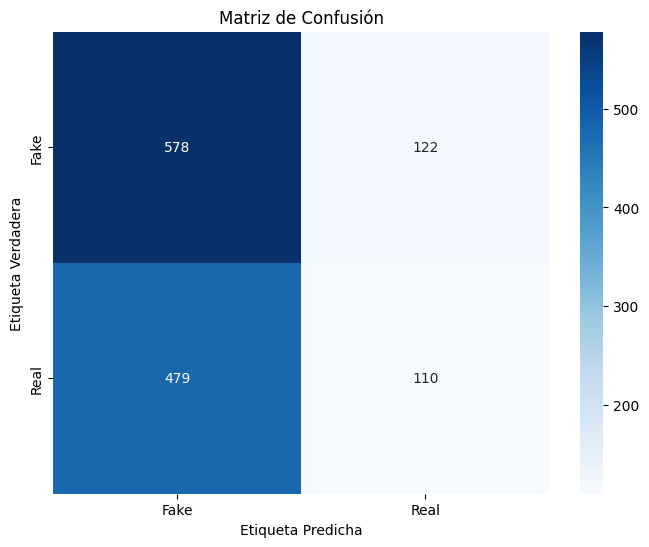


Reporte de Clasificación:
              precision    recall  f1-score   support

        Fake       0.55      0.83      0.66       700
        Real       0.47      0.19      0.27       589

    accuracy                           0.53      1289
   macro avg       0.51      0.51      0.46      1289
weighted avg       0.51      0.53      0.48      1289

Precisión Global: 0.5337470907680373


In [8]:
#@title Metricas

# Evaluación del modelo
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Pérdida en el conjunto de test: {test_loss}")
print(f"Precisión en el conjunto de test: {test_accuracy}")

# Generar predicciones
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = model.predict(test_dataset)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

# Matriz de Confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de Clasificación
print("\nReporte de Clasificación:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Precisión Global
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Precisión Global: {accuracy}")


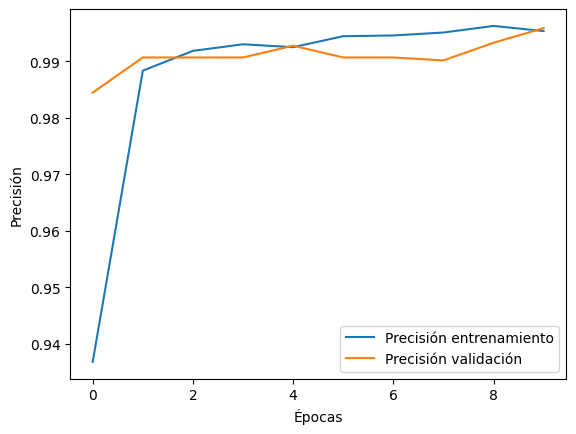

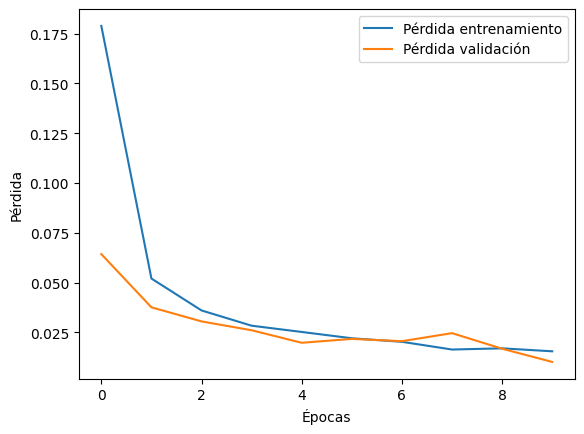

In [9]:
# Visualizar los resultados de entrenamiento
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()